# Regularization and Evaluation of Neural Networks

In [18]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [19]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [20]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['accuracy']
)

model.fit(X, y=y_binary, epochs=50, batch_size=360)

Epoch 1/50
5/5 [==============================] - 0s 375us/step - loss: 0.8602 - accuracy: 0.6566
Epoch 2/50
5/5 [==============================] - 0s 355us/step - loss: 0.6628 - accuracy: 0.7112
Epoch 3/50
5/5 [==============================] - 0s 294us/step - loss: 0.5757 - accuracy: 0.7524
Epoch 4/50
5/5 [==============================] - 0s 363us/step - loss: 0.5065 - accuracy: 0.7835
Epoch 5/50
5/5 [==============================] - 0s 373us/step - loss: 0.4481 - accuracy: 0.8041
Epoch 6/50
5/5 [==============================] - 0s 398us/step - loss: 0.3979 - accuracy: 0.8286
Epoch 7/50
5/5 [==============================] - 0s 370us/step - loss: 0.3594 - accuracy: 0.8486
Epoch 8/50
5/5 [==============================] - 0s 318us/step - loss: 0.3314 - accuracy: 0.8609
Epoch 9/50
5/5 [==============================] - 0s 245us/step - loss: 0.3084 - accuracy: 0.8720
Epoch 10/50
5/5 [==============================] - 0s 235us/step - loss: 0.2852 - accuracy: 0.8815
Epoch 11/50
5/5 [==

In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 12)                780       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 893
Trainable params: 893
Non-trainable params: 0
_________________________________________________________________


### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [22]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [23]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
                # We use binary_crossentropy for a binary loss function
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 252us/step - loss: 0.6949 - accuracy: 0.5039
Epoch 2/10
12/12 [==============================] - 0s 185us/step - loss: 0.6947 - accuracy: 0.5039
Epoch 3/10
12/12 [==============================] - 0s 262us/step - loss: 0.6945 - accuracy: 0.5030
Epoch 4/10
12/12 [==============================] - 0s 250us/step - loss: 0.6942 - accuracy: 0.5039
Epoch 5/10
12/12 [==============================] - 0s 253us/step - loss: 0.6941 - accuracy: 0.5039
Epoch 6/10
12/12 [==============================] - 0s 219us/step - loss: 0.6939 - accuracy: 0.5039
Epoch 7/10
12/12 [==============================] - 0s 195us/step - loss: 0.6938 - accuracy: 0.5022
Epoch 8/10
12/12 [==============================] - 0s 182us/step - loss: 0.6937 - accuracy: 0.5022
Epoch 9/10
12/12 [==============================] - 0s 194us/step - loss: 0.6935 - accuracy: 0.5022
Epoch 10/10
12/12 [==============================] - 0s 229us/step - loss: 0.6935 - accuracy: 0.5022

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [24]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f2ec3777ee0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6949339509010315,
   0.6946763396263123,
   0.6944588422775269,
   0.6942165493965149,
   0.6940560936927795,
   0.6939210891723633,
   0.6938394904136658,
   0.6936629414558411,
   0.6935493350028992,
   0.6934624314308167],
  'accuracy': [0.5039164423942566,
   0.5039164423942566,
   0.5030461549758911,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5021758079528809,
   0.5021758079528809,
   0.5021758079528809,
   0.5021758079528809]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

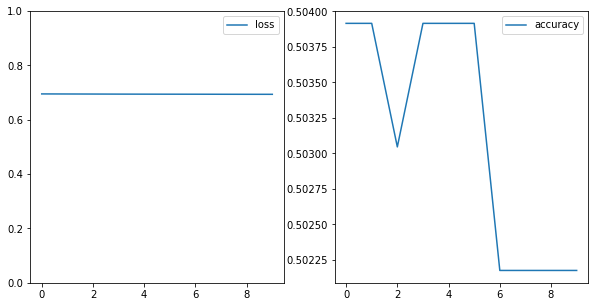

In [25]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(
    x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss').set(
    ylim=[0,1]
    )
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [26]:
X_pure_train.shape[0]

1149

In [27]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 245us/step - loss: 0.6967 - accuracy: 0.5057
Epoch 2/100
36/36 [==============================] - 0s 217us/step - loss: 0.6654 - accuracy: 0.5370
Epoch 3/100
36/36 [==============================] - 0s 214us/step - loss: 0.6397 - accuracy: 0.5857
Epoch 4/100
36/36 [==============================] - 0s 179us/step - loss: 0.6177 - accuracy: 0.6292
Epoch 5/100
36/36 [==============================] - 0s 186us/step - loss: 0.5994 - accuracy: 0.6771
Epoch 6/100
36/36 [==============================] - 0s 203us/step - loss: 0.5825 - accuracy: 0.7206
Epoch 7/100
36/36 [==============================] - 0s 192us/step - loss: 0.5657 - accuracy: 0.7380
Epoch 8/100
36/36 [==============================] - 0s 192us/step - loss: 0.5485 - accuracy: 0.7520
Epoch 9/100
36/36 [==============================] - 0s 152us/step - loss: 0.5308 - accuracy: 0.7659
Epoch 10/100
36/36 [==============================] - 0s 174us/step - loss: 0.5134 - accura

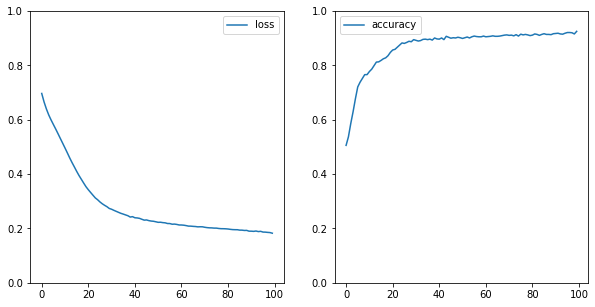

In [28]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss'
).set(ylim=[0,1])
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy'
).set(ylim=[0,1]);

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 202us/step - loss: 1.0519 - accuracy: 0.5196
Epoch 2/30
115/115 [==============================] - 0s 218us/step - loss: 1.0114 - accuracy: 0.5030
Epoch 3/30
115/115 [==============================] - 0s 185us/step - loss: 1.0269 - accuracy: 0.4778
Epoch 4/30
115/115 [==============================] - 0s 171us/step - loss: 0.9816 - accuracy: 0.5057
Epoch 5/30
115/115 [==============================] - 0s 256us/step - loss: 0.9419 - accuracy: 0.4917
Epoch 6/30
115/115 [==============================] - 0s 192us/step - loss: 0.9984 - accuracy: 0.5057
Epoch 7/30
115/115 [==============================] - 0s 182us/step - loss: 1.0061 - accuracy: 0.4943
Epoch 8/30
115/115 [==============================] - 0s 177us/step - loss: 0.9806 - accuracy: 0.5083
Epoch 9/30
115/115 [==============================] - 0s 169us/step - loss: 0.9564 - accuracy: 0.5126
Epoch 10/30
115/115 [==============================] - 0s 178us/step - loss: 0.984

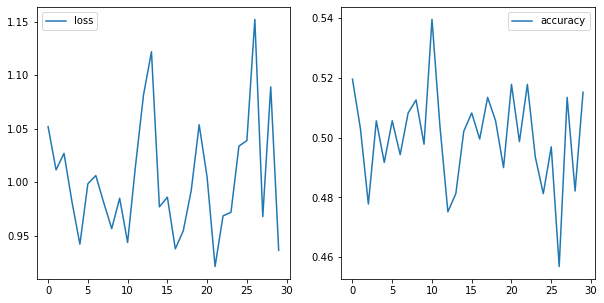

In [29]:
model = Sequential()

sgd = SGD(lr=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
            loss='binary_crossentropy',
            metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 0s 550us/step - loss: 0.6215 - accuracy: 0.5614 - val_loss: 0.5807 - val_accuracy: 0.6667
Epoch 2/30
115/115 [==============================] - 0s 309us/step - loss: 0.5280 - accuracy: 0.7702 - val_loss: 0.5165 - val_accuracy: 0.7639
Epoch 3/30
115/115 [==============================] - 0s 343us/step - loss: 0.4717 - accuracy: 0.8486 - val_loss: 0.4600 - val_accuracy: 0.8889
Epoch 4/30
115/115 [==============================] - 0s 316us/step - loss: 0.4269 - accuracy: 0.8825 - val_loss: 0.4247 - val_accuracy: 0.8715
Epoch 5/30
115/115 [==============================] - 0s 297us/step - loss: 0.3874 - accuracy: 0.9043 - val_loss: 0.3880 - val_accuracy: 0.9132
Epoch 6/30
115/115 [==============================] - 0s 284us/step - loss: 0.3528 - accuracy: 0.9130 - val_loss: 0.3475 - val_accuracy: 0.9306
Epoch 7/30
115/115 [==============================] - 0s 295us/step - loss: 0.3220 - accuracy: 0.9286 - val_loss: 0.3249 - val_accuracy:

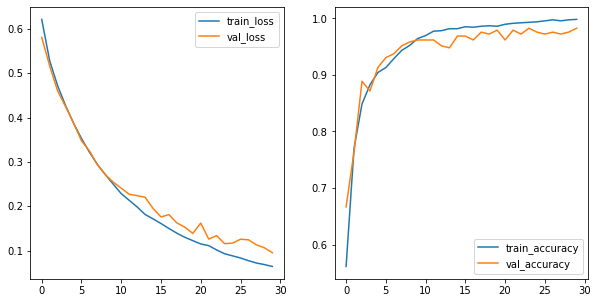

In [30]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(
    X_pure_train,y_pure_train,
    validation_data=(
        X_val,y_val
    ),
    # validation_split=0.3, # this gets the last n data
    epochs=30,
    batch_size=10,verbose=1
    )

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [31]:
# Model validation accuracy at the end
results.history['accuracy'][-1],results.history['val_accuracy'][-1]

(0.9982593655586243, 0.9826388955116272)

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [33]:
# This will throw an error.

# cross_val_score(model, X_pure_train, y_pure_train)

In [34]:
# Need to define a function to build the model
def build_model():
    model = Sequential()
    model.add(Dense(12,activation='relu',input_dim=64))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    
    return model

In [35]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                        epochs=50,
                                        batch_size=32,
                                        verbose=1)

In [36]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [37]:
cross_val_score(keras_model, X_pure_train, y_pure_train, cv=3)

Epoch 1/50
24/24 [==============================] - 0s 229us/step - loss: 0.6540 - accuracy: 0.6854
Epoch 2/50
24/24 [==============================] - 0s 216us/step - loss: 0.5979 - accuracy: 0.7768
Epoch 3/50
24/24 [==============================] - 0s 239us/step - loss: 0.5258 - accuracy: 0.8159
Epoch 4/50
24/24 [==============================] - 0s 242us/step - loss: 0.4512 - accuracy: 0.8381
Epoch 5/50
24/24 [==============================] - 0s 265us/step - loss: 0.3858 - accuracy: 0.8551
Epoch 6/50
24/24 [==============================] - 0s 260us/step - loss: 0.3396 - accuracy: 0.8681
Epoch 7/50
24/24 [==============================] - 0s 260us/step - loss: 0.3097 - accuracy: 0.8812
Epoch 8/50
24/24 [==============================] - 0s 231us/step - loss: 0.2850 - accuracy: 0.8903
Epoch 9/50
24/24 [==============================] - 0s 223us/step - loss: 0.2706 - accuracy: 0.8982
Epoch 10/50
24/24 [==============================] - 0s 226us/step - loss: 0.2551 - accuracy: 0.8982

array([0.92167103, 0.95561355, 0.92428195])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

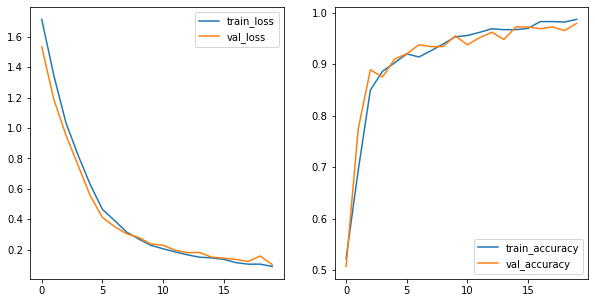

In [38]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',
    kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

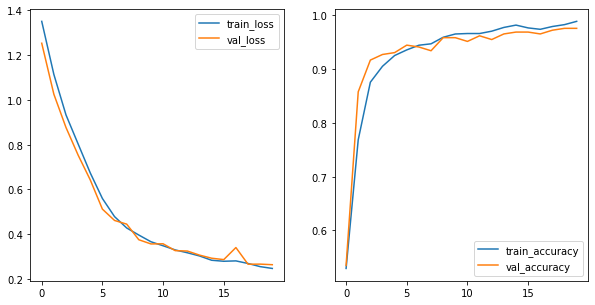

In [39]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

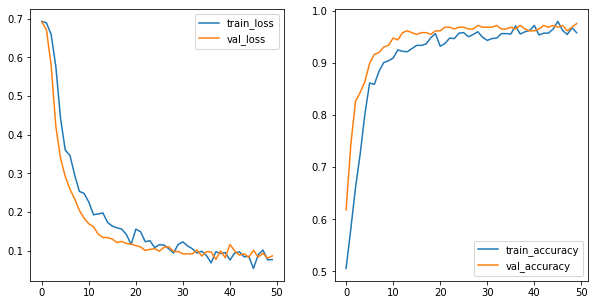

In [40]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dropout(rate=0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<!-- <details>
    <summary>One answer here</summary> -->
```python
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');
```
<!-- </details> -->

In [41]:
results.history['val_accuracy'][-1]

0.9756944179534912

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00009: early stopping


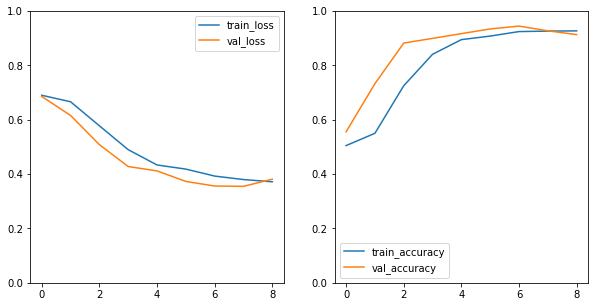

In [42]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(
    monitor='val_loss',min_delta=1e-8,
    verbose=1,mode='min'
)

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set(ylim=[0,1])
ax2.set(ylim=[0,1]);

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 1/100
36/36 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5117 - val_loss: 0.6877 - val_accuracy: 0.6458
Epoch 2/100
36/36 [==============================] - 0s 493us/step - loss: 0.6697 - accuracy: 0.5370 - val_loss: 0.6395 - val_accuracy: 0.6736
Epoch 3/100
36/36 [==============================] - 0s 498us/step - loss: 0.5894 - accuracy: 0.6980 - val_loss: 0.5372 - val_accuracy: 0.8229
Epoch 4/100
36/36 [==============================] - 0s 457us/step - loss: 0.5029 - accuracy: 0.8068 - val_loss: 0.4759 - val_accuracy: 0.8438
Epoch 5/100
36/36 [==============================] - 0s 680us/step - loss: 0.4455 - accuracy: 0.8277 - val_loss: 0.3967 - val_accuracy: 0.8750
Epoch 6/100
36/36 [==============================] - 0s 507us/step - loss: 0.3850 - accuracy: 0.8468 - val_loss: 0.3218 - val_accuracy: 0.8924
Epoch 7/100
36/36 [==============================] - 0s 583us/step - loss: 0.3199 - accuracy: 0.8660 - val_loss: 0.2715 - val_accuracy: 0.9097
E

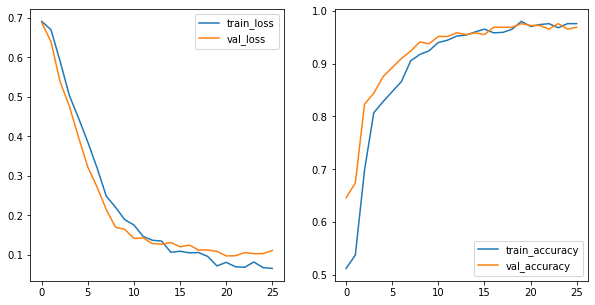

In [43]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                            verbose=1, patience=5,
                            mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=100, batch_size= 32,
                    verbose=1, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [44]:
results.history['val_accuracy'][-1]

0.96875

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [45]:
digits = load_digits()
X = digits.data
y = digits.target

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [47]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [48]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size=10,
                    validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 1ms/step - loss: 2.2940 - accuracy: 0.1305 - val_loss: 2.1584 - val_accuracy: 0.1840
Epoch 2/50
115/115 [==============================] - 0s 281us/step - loss: 2.0285 - accuracy: 0.2080 - val_loss: 1.8712 - val_accuracy: 0.2951
Epoch 3/50
115/115 [==============================] - 0s 289us/step - loss: 1.6708 - accuracy: 0.4517 - val_loss: 1.4539 - val_accuracy: 0.6146
Epoch 4/50
115/115 [==============================] - 0s 336us/step - loss: 1.2444 - accuracy: 0.6902 - val_loss: 1.0873 - val_accuracy: 0.7257
Epoch 5/50
115/115 [==============================] - 0s 294us/step - loss: 0.9368 - accuracy: 0.7537 - val_loss: 0.8916 - val_accuracy: 0.7708
Epoch 6/50
115/115 [==============================] - 0s 305us/step - loss: 0.7715 - accuracy: 0.7763 - val_loss: 0.7453 - val_accuracy: 0.8194
Epoch 7/50
115/115 [==============================] - 0s 280us/step - loss: 0.6615 - accuracy: 0.8016 - val_loss: 0.6770 - val_accuracy: 0

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [50]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

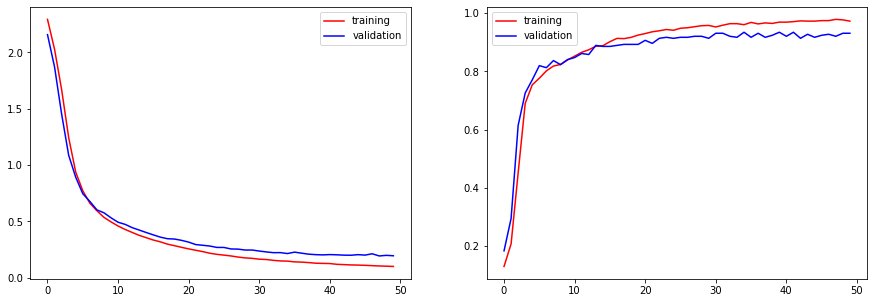

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
            y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
            y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
            y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
            y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [52]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

In [53]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[30,  0,  0,  0,  0,  1,  2,  0,  0,  0],
       [ 1, 25,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 30,  1,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  1, 32,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 45,  2,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  4,  1,  0,  0,  1,  0,  0, 24,  0],
       [ 0,  1,  0,  2,  0,  0,  0,  0,  1, 36]])

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
